In [76]:
from crocoddyl import *
import pinocchio as pin
import numpy as np

robot = loadBorinotArm()
robot.initViewer(loadModel=True)

q0 = [1, 0]
robot.q0.flat = q0
robot.framesForwardKinematics(robot.q0)
robot.display(robot.q0)

IDX_LINK1 = robot.model.getFrameId('link1', pin.FrameType.BODY)
IDX_LINK2 = robot.model.getFrameId('link2', pin.FrameType.BODY)
Mlink1 = robot.data.oMf[IDX_LINK1]
Mlink2 = robot.data.oMf[IDX_LINK2]

target_pos  = np.array([0,0,0.3])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

Mref = pin.SE3()
Mref.translation = target_pos.reshape(3,1)
Mref.rotation = target_quat.matrix()

#robot.viewer.gui.addXYZaxis('world/framelink1', [1., 0., 0., 1.], .005, 0.05)
#robot.viewer.gui.addXYZaxis('world/framelink2', [1., 0., 0., 1.], .005, 0.05)
#robot.viewer.gui.addXYZaxis('world/frameref', [1., 0., 0., 1.], .005, 0.05)

#robot.viewer.gui.applyConfiguration('world/framelink1', pin.se3ToXYZQUATtuple(Mlink1))
#robot.viewer.gui.applyConfiguration('world/framelink2', pin.se3ToXYZQUATtuple(Mlink2))
#robot.viewer.gui.applyConfiguration('world/frameref', pin.se3ToXYZQUATtuple(Mref))

robot.viewer.gui.refresh()

In [80]:
import time 
dt = 0.01
t = np.arange(0,20,dt)
q0 = np.array([[1, 0]]).T

q = q0
q_d = np.zeros([2,1])
q_dd = np.zeros([2,1])

for i in range(len(t)):
    pin.computeAllTerms(robot.model, robot.data, q, q_d)
    M = robot.data.M
    Minv = np.linalg.inv(M)
    nle = robot.data.nle
    q_dd = np.dot(Minv, m2a(-nle)).T
    q_d = q_d + q_dd*dt
    q = q + q_d*dt + 0.5*q_dd*dt**2
    print q_dd
    robot.framesForwardKinematics(q)
    robot.display(q)
    time.sleep(0.01)

[[ 83.50136921]
 [-85.98316903]]
[[ 84.70309115]
 [-90.32383132]]
[[ 86.59918836]
 [-96.95340459]]
[[  88.95862434]
 [-104.52228931]]
[[  91.37907111]
 [-110.6576778 ]]
[[  93.26402308]
 [-111.80199792]]
[[  93.88473349]
 [-103.51136159]]
[[ 92.5891125 ]
 [-81.58454278]]
[[ 89.10194306]
 [-43.82327148]]
[[83.65842531]
 [ 8.80182813]]
[[76.71813123]
 [72.86262902]]
[[ 68.38561553]
 [144.58298192]]
[[ 57.97665644]
 [221.42583416]]
[[ 44.0376546 ]
 [302.03973374]]
[[ 24.92095193]
 [384.74444739]]
[[1.95719954e-01]
 [4.64134205e+02]]
[[-26.19296193]
 [521.96147225]]
[[-39.55225879]
 [503.6501806 ]]
[[ -9.96926312]
 [296.59092812]]
[[  73.91310413]
 [-136.22981776]]
[[ 148.97427591]
 [-535.31189161]]
[[ 166.98309409]
 [-719.42755562]]
[[ 146.51320183]
 [-750.69994522]]
[[ 109.20935373]
 [-674.28917521]]
[[  59.57975477]
 [-475.74664519]]
[[  -4.1901011 ]
 [-152.58091458]]
[[-68.72550257]
 [190.22869197]]
[[-112.31675902]
 [ 406.88071122]]
[[-132.65670823]
 [ 473.9520921 ]]
[[-138.20051989]


[[  95.21246679]
 [-430.85174337]]
[[ 132.11278654]
 [-599.64080284]]
[[ 202.82458364]
 [-884.62393858]]
[[  321.52216601]
 [-1366.63146487]]
[[  268.98649449]
 [-1008.08162352]]
[[-398.71120681]
 [2258.42736303]]
[[-194.01322158]
 [1522.78813875]]
[[ -66.0986264 ]
 [1107.80765671]]
[[-18.5689496 ]
 [987.74689635]]
[[-23.7017946 ]
 [987.29968948]]
[[ -76.26833803]
 [1040.48434911]]
[[-171.57271032]
 [1135.40069004]]
[[-290.28349816]
 [1286.66888943]]
[[-357.17609641]
 [1348.85511713]]
[[-64.21631365]
 [125.35701102]]
[[  340.40041573]
 [-1398.57966306]]
[[  286.63369296]
 [-1270.13003312]]
[[  180.40311884]
 [-1071.37907941]]
[[  93.51573295]
 [-937.39879121]]
[[  33.99896246]
 [-820.2478418 ]]
[[   0.84653894]
 [-697.53582042]]
[[ -16.01788895]
 [-554.58070794]]
[[ -35.65165417]
 [-350.94246918]]
[[-74.80699978]
 [-49.90755813]]
[[-116.27087945]
 [ 236.39183042]]
[[-128.17399731]
 [ 345.81242248]]
[[-116.73314909]
 [ 316.70651465]]
[[-99.28201091]
 [243.55839948]]
[[-83.04847052]
 [16

[[ 26.13041353]
 [-44.48819887]]
[[ 36.74538689]
 [-55.72495503]]
[[ 46.94531134]
 [-64.877963  ]]
[[ 56.19143486]
 [-68.99372882]]
[[ 63.73164952]
 [-64.01389197]]
[[ 68.67058421]
 [-45.36536988]]
[[70.18943598]
 [-9.53939796]]
[[67.89087618]
 [43.50150744]]
[[ 62.10945112]
 [108.18330381]]
[[ 54.0679062 ]
 [172.64894496]]
[[ 46.04391163]
 [219.36772508]]
[[ 41.64436993]
 [226.47827587]]
[[ 45.21684947]
 [173.04158345]]
[[58.49237577]
 [54.73675112]]
[[ 75.73458546]
 [-96.44080104]]
[[  84.92117675]
 [-218.9545476 ]]
[[  76.66141736]
 [-260.26702542]]
[[  50.08470469]
 [-205.5482336 ]]
[[ 11.84267232]
 [-82.37179617]]
[[-27.42102492]
 [ 51.31363474]]
[[-58.11495362]
 [139.64556007]]
[[-75.89130485]
 [159.75777851]]
[[-81.8674171 ]
 [123.72677817]]
[[-80.38085949]
 [ 61.08370767]]
[[-76.33182785]
 [  0.68688289]]
[[-73.01317519]
 [-40.32473864]]
[[-71.40602927]
 [-58.22345596]]
[[-70.91124942]
 [-57.83831479]]
[[-70.44220094]
 [-46.730707  ]]
[[-69.11092764]
 [-31.57932285]]
[[-66.4399

[[-48.6591202 ]
 [-35.33036016]]
[[-45.30280144]
 [-18.1560103 ]]
[[-41.18028375]
 [ -3.47228741]]
[[-36.31055331]
 [  8.23877473]]
[[-30.752993  ]
 [ 16.89431943]]
[[-24.562603  ]
 [ 22.54197414]]
[[-17.7673784 ]
 [ 25.18989994]]
[[-10.36112827]
 [ 24.71120316]]
[[-2.30779796]
 [20.80514562]]
[[ 6.4452357 ]
 [13.00220828]]
[[15.94761635]
 [ 0.70133685]]
[[ 26.22448443]
 [-16.77322092]]
[[ 37.25928112]
 [-40.10670096]]
[[ 48.9880176 ]
 [-69.92033863]]
[[  61.30936062]
 [-106.65985101]]
[[  74.10408539]
 [-150.3532235 ]]
[[  87.22760786]
 [-200.01034473]]
[[ 100.3639441 ]
 [-252.12896834]]
[[ 112.47192832]
 [-297.16209322]]
[[ 120.4248982 ]
 [-312.52950067]]
[[ 117.38984496]
 [-256.10290556]]
[[ 95.83227724]
 [-86.16002238]]
[[ 59.53055363]
 [170.64096567]]
[[ 23.57188738]
 [414.91840366]]
[[ -6.23464559]
 [585.74401149]]
[[-32.73143312]
 [674.8707695 ]]
[[-49.20888686]
 [653.5151968 ]]
[[-31.21827102]
 [440.31461151]]
[[36.50306875]
 [ 5.56857873]]
[[ 107.79271225]
 [-434.85825414]]
[[

[[-38.57249179]
 [581.42279575]]
[[-13.29385079]
 [343.38621895]]
[[ 52.16445417]
 [-73.56528707]]
[[ 110.09433316]
 [-451.84843674]]
[[ 119.7892229 ]
 [-614.55118955]]
[[  87.62191767]
 [-562.09528143]]
[[  31.19611217]
 [-343.56105879]]
[[-33.0947353 ]
 [-44.39010665]]
[[-86.24521753]
 [206.60895785]]
[[-116.80104805]
 [ 327.48613058]]
[[-125.94586584]
 [ 325.80929981]]
[[-119.6420246 ]
 [ 247.28884654]]
[[-104.46480252]
 [ 138.06993357]]
[[-87.11782941]
 [ 35.35778559]]
[[-72.70545247]
 [-38.37280996]]
[[-63.13577599]
 [-77.77564417]]
[[-57.67874112]
 [-89.17893574]]
[[-54.61960373]
 [-82.58875361]]
[[-52.41821508]
 [-66.77879121]]
[[-50.0780015 ]
 [-47.83213259]]
[[-47.09128651]
 [-29.38625555]]
[[-43.27361812]
 [-13.32793489]]
[[-38.61689844]
 [ -0.44473448]]
[[-33.18886407]
 [  9.08197983]]
[[-27.07232153]
 [ 15.33538962]]
[[-20.33221028]
 [ 18.44105258]]
[[-13.00121193]
 [ 18.43418172]]
[[-5.07800055]
 [15.19319797]]
[[3.4654417 ]
 [8.42305511]]
[[12.66997581]
 [-2.32296555]]
[[

[[-7.3862281]
 [17.9888886]]
[[ 0.95362617]
 [12.2127348 ]]
[[9.93049893]
 [2.70221198]]
[[ 19.59044165]
 [-11.09793521]]
[[ 29.96012377]
 [-29.78803425]]
[[ 41.02980222]
 [-53.91089246]]
[[ 52.74049287]
 [-83.79659067]]
[[  64.96969864]
 [-119.28396644]]
[[  77.48929868]
 [-159.15046702]]
[[  89.82481966]
 [-199.90361665]]
[[ 100.87884353]
 [-233.37525776]]
[[ 108.20543558]
 [-242.93082892]]
[[ 107.43517832]
 [-201.55151629]]
[[ 94.07081751]
 [-83.83988552]]
[[ 69.05329555]
 [101.15124143]]
[[ 40.06902537]
 [299.74546908]]
[[ 12.95478515]
 [459.90177309]]
[[-11.04218896]
 [555.90404539]]
[[-26.46300557]
 [558.26338016]]
[[-17.11459336]
 [409.80418474]]
[[29.62247579]
 [81.81969978]]
[[  88.25931533]
 [-296.49424943]]
[[ 113.97799767]
 [-527.66151465]]
[[  97.01655132]
 [-553.24590557]]
[[  50.97038223]
 [-403.8912867 ]]
[[  -8.82153219]
 [-144.2131235 ]]
[[-64.87133927]
 [115.46289919]]
[[-102.66977291]
 [ 274.957943  ]]
[[-119.12161397]
 [ 312.00083814]]
[[-118.59043047]
 [ 259.84601

[[-42.78176051]
 [  9.9473726 ]]
[[-89.94810716]
 [223.81892905]]
[[-115.47762028]
 [ 313.36587185]]
[[-121.55917616]
 [ 294.78096329]]
[[-113.9819547 ]
 [ 211.94152741]]
[[-99.22496516]
 [107.78851959]]
[[-83.55709903]
 [ 15.53395994]]
[[-71.18120793]
 [-47.01743148]]
[[-63.24032851]
 [-77.75087931]]
[[-58.74835139]
 [-83.86538536]]
[[-56.09727147]
 [-74.78407601]]
[[-53.95667295]
 [-58.33177839]]
[[-51.50711351]
 [-39.78508537]]
[[-48.3562729 ]
 [-22.21772939]]
[[-44.38495965]
 [ -7.15509117]]
[[-39.61776535]
 [  4.83320843]]
[[-34.13567388]
 [ 13.68667593]]
[[-28.02342525]
 [ 19.54487931]]
[[-21.34122292]
 [ 22.54763608]]
[[-14.11287709]
 [ 22.7171358 ]]
[[-6.32543618]
 [19.9006657 ]]
[[ 2.06256345]
 [13.75898459]]
[[11.10622017]
 [ 3.7901477 ]]
[[ 20.85512513]
 [-10.61897072]]
[[ 31.33358805]
 [-30.11935414]]
[[ 42.52490435]
 [-55.30402682]]
[[ 54.36293033]
 [-86.56847274]]
[[  66.7264687 ]
 [-123.85724207]]
[[  79.41040077]
 [-166.12440254]]
[[  91.99858162]
 [-210.13538748]]
[[ 1

[[  87.55403015]
 [-195.19344291]]
[[  99.66487185]
 [-236.9650072 ]]
[[ 109.36801992]
 [-263.09284469]]
[[ 112.76924585]
 [-248.27397375]]
[[ 104.11138513]
 [-158.57811079]]
[[80.85562344]
 [18.18816945]]
[[ 49.73804235]
 [236.59665806]]
[[ 19.89348339]
 [427.97186855]]
[[ -6.57568763]
 [557.12306775]]
[[-27.99881266]
 [604.17723866]]
[[-31.78761728]
 [521.28354431]]
[[  2.29523335]
 [246.00003427]]
[[  66.96431093]
 [-163.51303627]]
[[ 112.58144413]
 [-485.70491988]]
[[ 111.3601755 ]
 [-594.04042817]]
[[  73.66009675]
 [-503.91424687]]
[[  15.74089336]
 [-267.66196084]]
[[-45.70470386]
 [ 19.07405573]]
[[-92.95177596]
 [235.21055154]]
[[-117.93392088]
 [ 322.76003217]]
[[-123.30427851]
 [ 301.0132265 ]]
[[-115.03466226]
 [ 215.33930787]]
[[-99.64983871]
 [109.01643365]]
[[-83.47018696]
 [ 15.32046063]]
[[-70.73504079]
 [-47.9962338 ]]
[[-62.57365432]
 [-79.00999985]]
[[-57.95671404]
 [-85.14365561]]
[[-55.23633086]
 [-75.97409116]]
[[-53.05698295]
 [-59.39849379]]
[[-50.58562977]
 [-

In [67]:
state = StatePinocchio(robot.model)

xRegCost = CostModelState(robot.model, state, ref=state.zero(), nu=1)
uRegCost = CostModelControl(robot.model, nu = 1)
xPendCost = CostModelDoublePendulum(robot.model, 
                                    frame=state, 
                                    ref=state.zero, 
                                    nu=1,
                                    activation=ActivationModelWeightedQuad(np.np.array([1]*4+[0.001]*2))) 

runningCostModel = CostModelSum(robot.model, nu=1)
terminalCostModel = CostModelSum(robot.model, nu=1)

runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
runningCostModel.addCost(name="pend", weight=0.1, cost=xPendCost)
terminalCostModel.addCost(name="ori2", weight=100, cost=xPendCost)

In [68]:
actModel = ActuationModelDoublePendulum(robot.model)
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [69]:
# Defining the time duration for running action models and the terminal one
dt = 5e-2
runningModel.timeStep = dt

# For this optimal control problem, we define 250 knots (or running action
# models) plus a terminal knot
T = 100
x0 = np.np.array([3.14, 0, 0., 0. ])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

In [74]:
xs = [np.np.array([3.14, 0.  , 0.  , 0.  ]),
 np.array([  3.71059542,  -2.05541894,  11.41190835, -41.10837881]),
 np.array([  3.76668242,  -2.83395101,   1.12174006, -15.5706414 ]),
 np.array([ 3.89056434, -2.99656298,  2.47763835, -3.25223937]),
 np.array([ 3.71635446, -3.12552479, -3.48419748, -2.57923624]),
 np.array([ 3.5244489 , -2.92584309, -3.83811128,  3.99363411]),
 np.array([  2.92679904,  -2.97209156, -11.95299728,  -0.92496958]),
 np.array([  2.338523  ,  -2.87566759, -11.76552081,   1.92847956]),
 np.array([ 1.95375756, -2.56138768, -7.69530875,  6.28559803]),
 np.array([ 1.77584689, -2.1567364 , -3.55821333,  8.09302574]),
 np.array([ 1.72344537, -1.86560016, -1.04803039,  5.82272469]),
 np.array([ 1.367794  , -1.5842915 , -7.11302751,  5.62617331]),
 np.array([ 1.34280047, -1.42985981, -0.49987048,  3.08863373]),
 np.array([ 1.44705705, -1.50587472,  2.08513161, -1.52029819]),
 np.array([ 1.54391907, -1.58254265,  1.93724031, -1.53335868]),
 np.array([ 1.51479801, -1.53731134, -0.58242123,  0.90462621]),
 np.array([ 1.44800478, -1.46329318, -1.33586448,  1.48036335]),
 np.array([ 1.40542619, -1.41846823, -0.85157192,  0.89649887]),
 np.array([ 1.36151447, -1.37544602, -0.8782344 ,  0.86044414]),
 np.array([ 1.29170425, -1.29740573, -1.39620442,  1.56080594]),
 np.array([ 1.21684746, -1.2021926 , -1.49713579,  1.90426261]),
 np.array([ 1.16579769, -1.13015334, -1.02099531,  1.44078521]),
 np.array([ 1.18899947, -1.18593751,  0.4640355 , -1.11568352]),
 np.array([ 1.18923678, -1.19305194,  0.00474629, -0.14228851]),
 np.array([ 1.18450234, -1.19285596, -0.09468873,  0.00391948]),
 np.array([ 1.16938901, -1.17758861, -0.30226665,  0.30534706]),
 np.array([ 1.14860889, -1.1556876 , -0.41560239,  0.43802026]),
 np.array([ 1.12381992, -1.12905946, -0.49577947,  0.53256269]),
 np.array([ 1.09763939, -1.10139022, -0.5236106 ,  0.55338486]),
 np.array([ 1.07129065, -1.07415824, -0.52697478,  0.54463952]),
 np.array([ 1.04520189, -1.04775071, -0.52177524,  0.52815074]),
 np.array([ 1.01925473, -1.02176134, -0.51894314,  0.51978733]),
 np.array([ 0.99326029, -0.99576573, -0.51988888,  0.51991216]),
 np.array([ 0.96713226, -0.96957085, -0.52256045,  0.52389762]),
 np.array([ 0.94089059, -0.94318632, -0.52483347,  0.52769065]),
 np.array([ 0.91460743, -0.91671151, -0.52566331,  0.52949614]),
 np.array([ 0.88836448, -0.89025679, -0.52485899,  0.52909444]),
 np.array([ 0.8622333 , -0.86391161, -0.52262358,  0.52690367]),
 np.array([ 0.83627113, -0.83774103, -0.51924341,  0.52341162]),
 np.array([ 0.81052314, -0.81179221, -0.51495979,  0.51897629]),
 np.array([ 0.78502583, -0.7861013 , -0.50994604,  0.51381814]),
 np.array([ 0.75980973, -0.76069794, -0.50432205,  0.50806732]),
 np.array([ 0.73490108, -0.73560765, -0.49817305,  0.50180573]),
 np.array([ 0.71032295, -0.71085309, -0.49156268,  0.49509113]),
 np.array([ 0.68609592, -0.68645468, -0.48454062,  0.48796838]),
 np.array([ 0.66223857, -0.66243097, -0.4771469 ,  0.48047417]),
 np.array([ 0.63876784, -0.638799  , -0.46941458,  0.47263926]),
 np.array([ 0.61569926, -0.61557451, -0.46137163,  0.46448992]),
 np.array([ 0.59304714, -0.59277205, -0.45304233,  0.45604915]),
 np.array([ 0.57082472, -0.57040516, -0.44444851,  0.44733776]),
 np.array([ 0.5490442 , -0.5484864 , -0.43561042,  0.43837527]),
 np.array([ 0.52771682, -0.52702737, -0.42654753,  0.42918064]),
 np.array([ 0.50685287, -0.50603872, -0.41727905,  0.41977288]),
 np.array([ 0.48646165, -0.48553015, -0.40782438,  0.41017143]),
 np.array([ 0.46655148, -0.46551033, -0.39820344,  0.40039651]),
 np.array([ 0.44712963, -0.44598686, -0.38843682,  0.39046924]),
 np.array([ 0.42820234, -0.42696627, -0.37854593,  0.38041178]),
 np.array([ 0.40977469, -0.40845391, -0.36855301,  0.37024729]),
 np.array([ 0.39185063, -0.39045392, -0.35848111,  0.35999991]),
 np.array([ 0.37443293, -0.37296918, -0.34835401,  0.34969464]),
 np.array([ 0.35752313, -0.35600132, -0.33819611,  0.33935717]),
 np.array([ 0.34112151, -0.33955064, -0.32803223,  0.32901368]),
 np.array([ 0.32522714, -0.32361611, -0.31788744,  0.31869062]),
 np.array([ 0.3098378 , -0.30819539, -0.30778687,  0.30841447]),
 np.array([ 0.29495002, -0.29328481, -0.29775549,  0.29821151]),
 np.array([ 0.28055913, -0.27887943, -0.28781785,  0.28810754]),
 np.array([ 0.26665924, -0.26497305, -0.27799791,  0.27812764]),
 np.array([ 0.2532433 , -0.25155825, -0.26831881,  0.26829597]),
 np.array([ 0.24030316, -0.23862648, -0.25880271,  0.25863553]),
 np.array([ 0.22782963, -0.22616808, -0.24947056,  0.249168  ]),
 np.array([ 0.21581253, -0.2141724 , -0.240342  ,  0.23991356]),
 np.array([ 0.20424077, -0.20262786, -0.23143524,  0.23089078]),
 np.array([ 0.19310242, -0.19152203, -0.22276693,  0.22211657]),
 np.array([ 0.18238482, -0.18084173, -0.21435216,  0.21360604]),
 np.array([ 0.1720746 , -0.1705731 , -0.20620435,  0.20537255]),
 np.array([ 0.16215783, -0.16070172, -0.1983353 ,  0.19742769]),
 np.array([ 0.15262007, -0.15121265, -0.19075521,  0.18978131]),
 np.array([ 0.14344644, -0.14209057, -0.18347268,  0.1824416 ]),
 np.array([ 0.1346217 , -0.13331981, -0.17649481,  0.17541513]),
 np.array([ 0.12613034, -0.12488446, -0.16982728,  0.16870702]),
 np.array([ 0.11795661, -0.11676841, -0.16347443,  0.162321  ]),
 np.array([ 0.11008464, -0.10895544, -0.1574394 ,  0.15625955]),
 np.array([ 0.10249843, -0.10142923, -0.1517242 ,  0.15052409]),
 np.array([ 0.09518194, -0.09417348, -0.14632985,  0.14511507]),
 np.array([ 0.08811912, -0.08717187, -0.14125652,  0.14003219]),
 np.array([ 0.08129394, -0.08040814, -0.13650357,  0.13527455]),
 np.array([ 0.07469045, -0.0738661 , -0.13206966,  0.13084086]),
 np.array([ 0.06829281, -0.06752961, -0.12795279,  0.12672967]),
 np.array([ 0.0620853 , -0.06138263, -0.12415021,  0.12293963]),
 np.array([ 0.05605239, -0.05540914, -0.12065827,  0.11946986]),
 np.array([ 0.05017879, -0.04959312, -0.11747205,  0.11632045]),
 np.array([ 0.04444955, -0.04391845, -0.11458473,  0.11349339]),
 np.array([ 0.03885023, -0.03836872, -0.11198653,  0.11099465]),
 np.array([ 0.03336706, -0.03292676, -0.10966334,  0.10883912]),
 np.array([ 0.02798731, -0.02757362, -0.10759493,  0.10706279]),
 np.array([ 0.02269973, -0.02228629, -0.10575156,  0.10574658]),
 np.array([ 0.01749586, -0.01703493, -0.10407742,  0.10502727]),
 np.array([ 0.01237456, -0.01178555, -0.10242597,  0.10498748]),
 np.array([ 0.00735098, -0.00651136, -0.10047168,  0.10548388]),
 np.array([ 0.00245966, -0.00117719, -0.09782643,  0.10668329]),
 np.array([-0.00194355,  0.0032169 , -0.08806415,  0.08788188])]

NameError: name 'array' is not defined

In [70]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve()

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  1.23861e-01  1.86586e+02  -1.56928e+06  1.00000e+02  1.00000e+02   0.0312     0
   1  2.87954e-01  1.72339e+03  -1.52928e+06  1.00000e+02  1.00000e+02   0.0156     0
   2  5.39916e-01  3.56269e+03  -1.49132e+06  1.00000e+02  1.00000e+02   0.0156     0
   3  8.96508e-01  7.01725e+03  -1.45873e+06  1.00000e+02  1.00000e+02   0.0156     0
   4  1.37132e+00  1.33917e+04  -1.43153e+06  1.00000e+02  1.00000e+02   0.0156     0
   5  1.96286e+00  2.45857e+04  -1.40971e+06  1.00000e+02  1.00000e+02   0.0156     0
   6  2.63553e+00  4.20907e+04  -1.39320e+06  1.00000e+02  1.00000e+02   0.0156     0
   7  3.31405e+00  6.44937e+04  -1.38188e+06  1.00000e+02  1.00000e+02   0.0156     0
   8  4.61426e+00  8.64758e+04  -1.33121e+06  1.00000e+02  1.00000e+02   0.0312     0
   9  4.32704e+00  1.36846e+05  -1.46865e+06  1.00000e+02  1.00000e+02   0.0156     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10

  89  8.49725e+00  4.13776e+03  4.24999e-03  1.00000e+01  1.00000e+01   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  90  8.49312e+00  3.99976e+03  4.16077e-03  1.00000e+01  1.00000e+01   1.0000     1
  91  8.48907e+00  3.87546e+03  4.07979e-03  1.00000e+01  1.00000e+01   1.0000     1
  92  8.48508e+00  3.76352e+03  4.00626e-03  1.00000e+01  1.00000e+01   1.0000     1
  93  8.48117e+00  3.66274e+03  3.93949e-03  1.00000e+01  1.00000e+01   1.0000     1
  94  8.47731e+00  3.57204e+03  3.87882e-03  1.00000e+01  1.00000e+01   1.0000     1
  95  8.47351e+00  3.49042e+03  3.82368e-03  1.00000e+01  1.00000e+01   1.0000     1
  96  8.46975e+00  3.41700e+03  3.77354e-03  1.00000e+01  1.00000e+01   1.0000     1
  97  8.46604e+00  3.35096e+03  3.72793e-03  1.00000e+01  1.00000e+01   1.0000     1
  98  8.46238e+00  3.29159e+03  3.68642e-03  1.00000e+01  1.00000e+01   1.0000     1
  99  8.45874e+00  3.23822e+03  3.64861e-03  1.00000e+01  1.00000e+01   1.0000    

 179  8.19921e+00  2.65083e+03  3.11627e-03  1.00000e+01  1.00000e+01   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
 180  8.19610e+00  2.64737e+03  3.11387e-03  1.00000e+01  1.00000e+01   1.0000     1
 181  8.19300e+00  2.64388e+03  3.11148e-03  1.00000e+01  1.00000e+01   1.0000     1
 182  8.18989e+00  2.64037e+03  3.10909e-03  1.00000e+01  1.00000e+01   1.0000     1
 183  8.18679e+00  2.63683e+03  3.10670e-03  1.00000e+01  1.00000e+01   1.0000     1
 184  8.18370e+00  2.63328e+03  3.10431e-03  1.00000e+01  1.00000e+01   1.0000     1
 185  8.18060e+00  2.62970e+03  3.10193e-03  1.00000e+01  1.00000e+01   1.0000     1
 186  8.17751e+00  2.62611e+03  3.09954e-03  1.00000e+01  1.00000e+01   1.0000     1
 187  8.17442e+00  2.62249e+03  3.09716e-03  1.00000e+01  1.00000e+01   1.0000     1
 188  8.17133e+00  2.61886e+03  3.09479e-03  1.00000e+01  1.00000e+01   1.0000     1
 189  8.16824e+00  2.61521e+03  3.09241e-03  1.00000e+01  1.00000e+01   1.0000    

([array([3.14, 0.  , 0.  , 0.  ]),
  array([  3.71059542,  -2.05541894,  11.41190835, -41.10837881]),
  array([  3.76668242,  -2.83395101,   1.12174006, -15.5706414 ]),
  array([ 3.89056434, -2.99656298,  2.47763835, -3.25223937]),
  array([ 3.71635446, -3.12552479, -3.48419748, -2.57923624]),
  array([ 3.5244489 , -2.92584309, -3.83811128,  3.99363411]),
  array([  2.92679904,  -2.97209156, -11.95299728,  -0.92496958]),
  array([  2.338523  ,  -2.87566759, -11.76552081,   1.92847956]),
  array([ 1.95375756, -2.56138768, -7.69530875,  6.28559803]),
  array([ 1.77584689, -2.1567364 , -3.55821333,  8.09302574]),
  array([ 1.72344537, -1.86560016, -1.04803039,  5.82272469]),
  array([ 1.367794  , -1.5842915 , -7.11302751,  5.62617331]),
  array([ 1.34280047, -1.42985981, -0.49987048,  3.08863373]),
  array([ 1.44705705, -1.50587472,  2.08513161, -1.52029819]),
  array([ 1.54391907, -1.58254265,  1.93724031, -1.53335868]),
  array([ 1.51479801, -1.53731134, -0.58242123,  0.90462621]),
  ar

In [71]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

In [72]:
ddp.xs

[array([3.14, 0.  , 0.  , 0.  ]),
 array([  3.71059542,  -2.05541894,  11.41190835, -41.10837881]),
 array([  3.76668242,  -2.83395101,   1.12174006, -15.5706414 ]),
 array([ 3.89056434, -2.99656298,  2.47763835, -3.25223937]),
 array([ 3.71635446, -3.12552479, -3.48419748, -2.57923624]),
 array([ 3.5244489 , -2.92584309, -3.83811128,  3.99363411]),
 array([  2.92679904,  -2.97209156, -11.95299728,  -0.92496958]),
 array([  2.338523  ,  -2.87566759, -11.76552081,   1.92847956]),
 array([ 1.95375756, -2.56138768, -7.69530875,  6.28559803]),
 array([ 1.77584689, -2.1567364 , -3.55821333,  8.09302574]),
 array([ 1.72344537, -1.86560016, -1.04803039,  5.82272469]),
 array([ 1.367794  , -1.5842915 , -7.11302751,  5.62617331]),
 array([ 1.34280047, -1.42985981, -0.49987048,  3.08863373]),
 array([ 1.44705705, -1.50587472,  2.08513161, -1.52029819]),
 array([ 1.54391907, -1.58254265,  1.93724031, -1.53335868]),
 array([ 1.51479801, -1.53731134, -0.58242123,  0.90462621]),
 array([ 1.44800478,

3.7

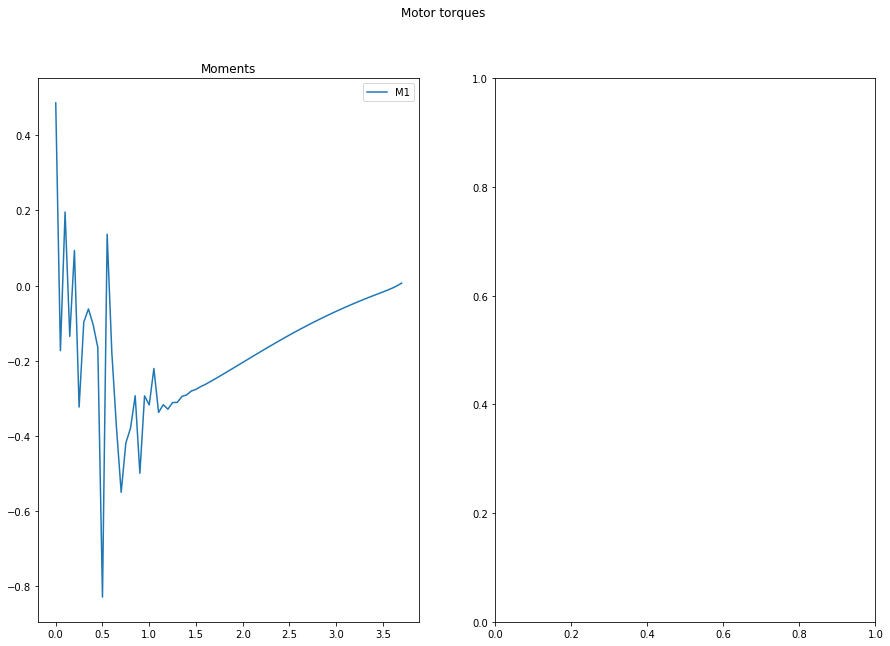

In [58]:
import numpy as np
import matplotlib.pyplot as plt

control = np.vstack(ddp.us)
t = np.arange(0,T*dt, dt)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('Motor torques')
# axs[0].plot(t,control[:,0], t,control[:,1])
axs[0].plot(t,control[:,0])
axs[0].set_title('Moments')
axs[0].legend(['M1','M2'])

t_state = t
t_state[-1]